In [1]:
import gym
import numpy as np
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
from itertools import count
from collections import namedtuple
from PIL import Image
import random
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
'''
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. 
The system is controlled by applying a force of +1 or -1 to the cart. 
The pendulum starts upright, and the goal is to prevent it from falling over. 
A reward of +1 is provided for every timestep that the pole remains upright. 
The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.
Actions: [Left, Right]
States: [position of cart, velocity of cart, angle of pole, rotation rate of pole]
'''
env = gym.make('CartPole-v0')
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory():
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity 
        # a cyclic buffer of bounded size that holds the transitions observed recently
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [4]:
class DQN(nn.Module):
    
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2) # 3 input channels, 16 output channels, padding=0
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 5, 2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, 5, 2)
        self.bn3 = nn.BatchNorm2d(32)
        
        def conv2d_size_out(size, kernel_size=5, stride=2):
            return (size - kernel_size) // stride + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w))) # there were three convolution layers
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        self.linera_input_size = 32 * convh * convw
        self.head = nn.Linear(self.linera_input_size, outputs) # pay attention, it's in the init block
        # as we will know later, the screen size is 3x40x90, so the linear input size would be 2x8x32 = 512
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(-1, self.linera_input_size)) # input size must be reshaped to [n, linear_input_size] !!!

In [5]:
resize = T.Compose([
    T.ToPILImage(),
    T.Resize(40, interpolation=Image.CUBIC),
    T.ToTensor()
])

'''
In DQN algorithm, states are the screens the agent observed, so we need to get the screens. The original screen 
requested by gym is not efficient for network to train, for there were only a little parts of the screen are being 
updated and others have the same pixels between different screens. So we need to properly cut down the screen and 
then scale down it(use the composed transformations "resize")!!
'''


'''
At first we need to determine the cart's location in the new scale. From the beginning, the cart activate in 
range (-2.4, 2.4). It's too narrow to observe for human, so we'd like to rescale it and let it move in range (0, 600)
Attention: in the original coordinate system, the y-axis is in the middle, after rescale y-axis is on the far left.
'''
def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    # according to the plot scale and the change of y-axis, the new position of the cart should be (screen_width / 2.0) plus
    # the distance to the middle under new scarle
    cart_location = int(env.state[0] * scale + screen_width / 2.0)
    return cart_location


'''
After get the new location of the cart, we need to get the new screen.
'''
def get_screen():
    # the screen requested by gym is HWC: 400x600x3, so we need to transpose it into torch order CHW: 3x400x600
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    
    # then extract screen's H and W, discard the Color channel
    _, screen_height, screen_width = screen.shape # screen shape (3, 400, 600)
    
    # cart is in the lower half. so strip off the top and bottom of the screen
    screen = screen[:, int(screen_height*0.4):int(screen_height*0.8)] # screen shape: (3, 160, 600)
    
    # we want a square input
    view_width = int((4/15) * screen_width) # use 'int' to slice
    cart_location = get_cart_location(screen_width)
    
    # then judge which side does cart_location tends to
    if cart_location < view_width//2: # left 60%
        slice_range = slice(None, view_width, None) # slice(start, end, step)
    elif cart_location > (screen_width - view_width//2): # right 60%
        slice_range = slice(-view_width, None, None)
    else:
        slice_range = slice(cart_location - view_width//2, cart_location + view_width//2, None)
        
    # so that we can strip off the edgs
    screen = screen [:, :, slice_range] # 3 x 160 x 160
    
    # convert to float, rescale, convert to torch
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    
    # then resize it. And since conv2d should have input size BCHW, so we need to add a batch dimension by using unsqueeze
    # unsqueeze Returns a new tensor with a dimension of size one inserted at the specified position
    # the dimension BATCH is useful during action selection and optimization.
    return resize(screen).unsqueeze(0).to(device) # [1, 3, 40, 40]

In [6]:
env.reset()
# plt.figure()
# plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation='none')
# plt.title('Example extracted screen')
# plt.show()

array([-0.03257452,  0.00201982, -0.02913759, -0.00568774])

In [7]:
# define some hyperparameters
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10 # update target policy every 10 episodes

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device) # same network
target_net.load_state_dict(policy_net.state_dict()) # fixed policy, update every 10 episodes
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0
episode_durations = []

In [8]:
def select_action(state):
    global steps_done # we need to decay epsilon along episodes
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1.0 * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
            # state: (1, 3, 40, 90); 
            # policy_net(state) returns: tensor([[Q(state, left), Q(state, right)]])
            # max(1) find the max along columns:
            # torch.return_types.max(values=tensor([Q(state, left) or Q(state, right)]), indices=tensor([0 or 1]))
            # so max(1)[1] is the index of where max element was found
            # use view(1, 1) then we get the argmax value tensor([[0 or 1]])
            # use .item() can get action
            
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [9]:
def plot_durations(clear=True, save=False):
    plt.figure(1, figsize=(18, 12))
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...', fontsize=25)
    plt.xlabel('Episode', fontsize=25)
    plt.ylabel('Duration', fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.plot(durations_t.numpy())
    if save:
        plt.savefig("durations.png")
    plt.show()
    if clear:
        clear_output(wait=True)
        time.sleep(0.1)

In [10]:
def plot_mean_durations(clear=True, save=False):
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if len(durations_t) >= 100:
        # use unfold: Returns a tensor which contains all slices of size size from self tensor in the dimension dimension.
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.figure(2, figsize=(18, 12))
        plt.clf()
        plt.title("Mean Durations", fontsize=25, color='r')
        plt.xlabel('episode', fontsize=25)
        plt.ylabel('mean durations', fontsize=25)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.plot(means.numpy())
        if save:
            plt.savefig("mean_durations.png")
        plt.show()
        if clear:
            clear_output(wait=True)
            time.sleep(0.1)

In [11]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    
    # 'batch' is a namedtuple
    batch = Transition(*zip(*transitions))
    
    # batch.state is a tuple with length=BATCH_SIZE!! Each element is a tensor, then we concatnate them along axis=0.
    # One state's shape is 1x3x40x90, after concatnate state_batch's shape is 128x3x40x90
    # as for next_state, we should consider whether it's None
    state_batch = torch.cat(batch.state) # BATCH_SIZE x 3 x 40 x 90
    action_batch = torch.cat(batch.action) # BATCH_SIZE x 1
    reward_batch = torch.cat(batch.reward) # BATCH_SIZE
    non_final_next_state = torch.cat([s for s in batch.next_state if s is not None])
    
    # compute Q(s_t, a)
    # attention: the network returns tensor([[Q1,Q2], [Q3,Q4], [Q5,Q6], ...]) with size BATCH_SIZE x 2, but these are all Q(s_t)
    # so we need to select the actions taken. These are the actions which would've been taken for each batch state
    # according to policy_net.
    state_action_values = policy_net(state_batch).gather(1, action_batch) # along axis=1, that is x-axis. Size: BATCH_SIZE x 1
    
    # initialize next state values
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    
    # generate a index mask
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    
    # use target_policy to compute next state value, the maximum Q of each state
    # use .detach() to stop a tensor from tracking history, detach it from the computation history, 
    # and to prevent future computation from being tracked.
    next_state_values[non_final_mask] = target_net(non_final_next_state).max(1)[0].detach()
    
    # compute the estimated value
    expected_state_action_value = (next_state_values * GAMMA) + reward_batch # size: 1 x BATCH_SIZE
    '''
    Attention: state_action_values is BATCH_SIZE x 1, expected_state_action_value is 1x BATCH_SIZE, they are not Q tables!
    Each (state, action, reward, next_state) is a matched tulple and there are 128(BATCH_SIZE) pairs in total!!!
    '''
    
    # compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_value.unsqueeze(1)) # size 1 x 1
    # optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1) # squeeze the gradient between -1 and 1
    optimizer.step()

Complete！！！


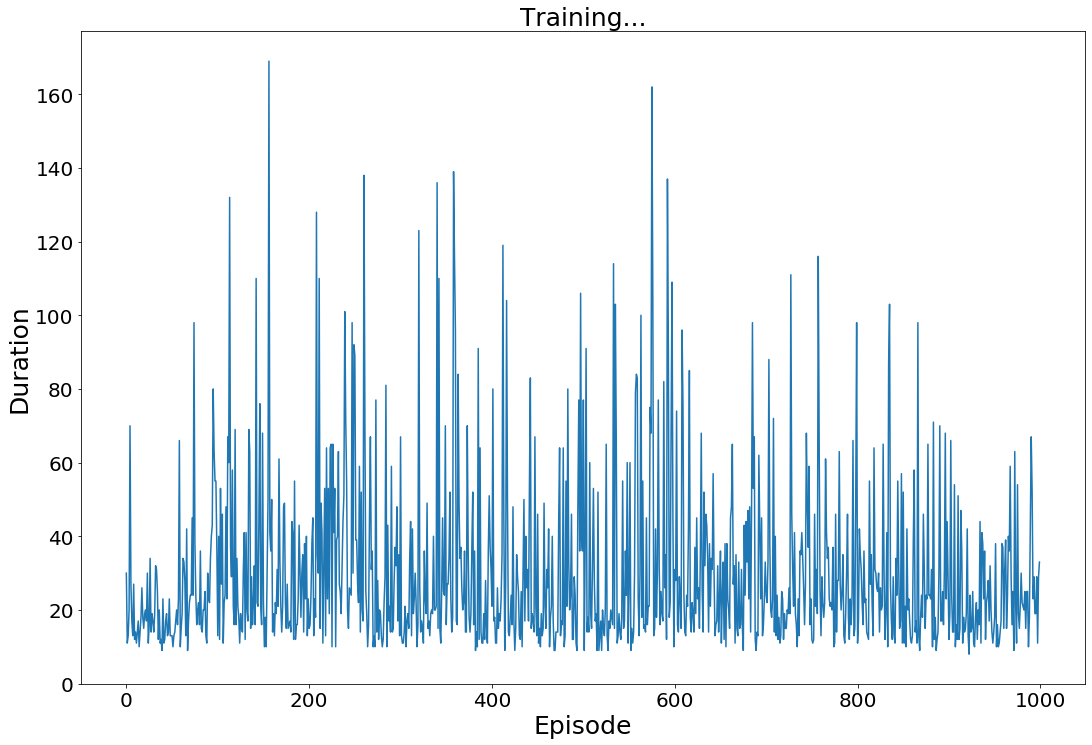

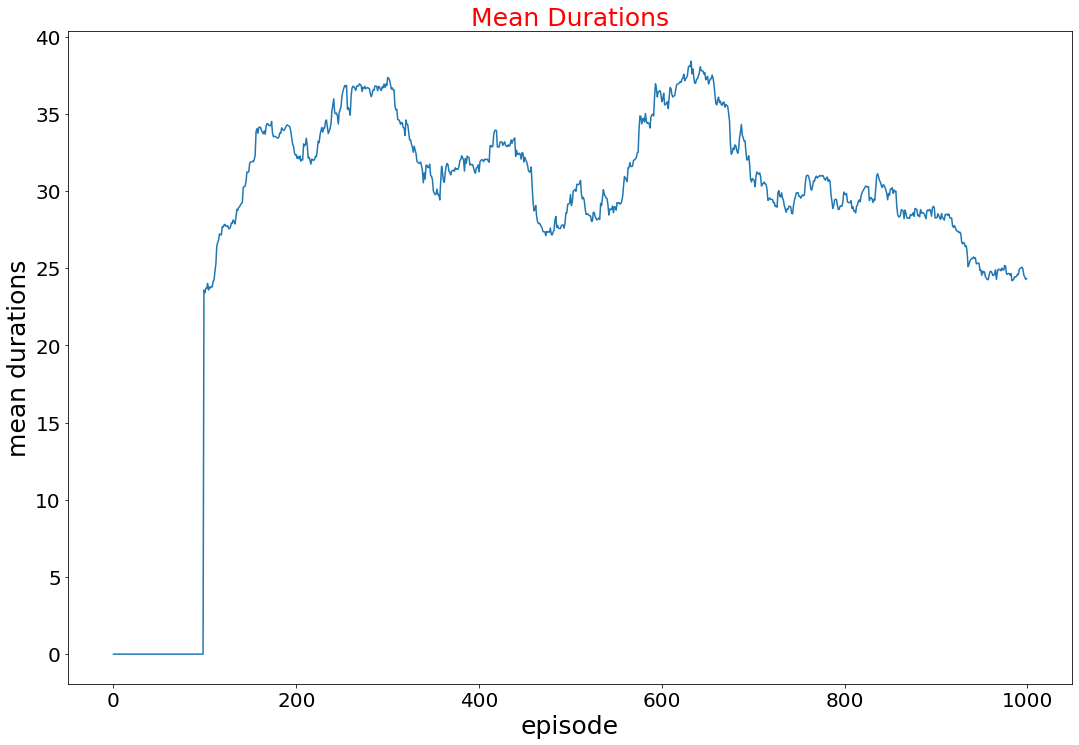

done


In [12]:
num_episode = 1000
episode_durations = []
for i in range(num_episode):
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)      
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None    
        memory.push(state, action, next_state, reward)   
        state = next_state
        
        # for each step we will optimize the model with BATCH_SIZE = 128, there's no need to sample from memory again and
        # again until run out thr repertory.
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            if i < 100 :
                plot_durations()
            else:
                plot_mean_durations()
            break
    if i % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
print("Complete！！！")
plot_durations(clear=False, save=True)
plot_mean_durations(clear=False, save=True)
print('done')